In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
!pip install duckdb halo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for halo: filename=halo-0.0.31-py3-none-any.whl size=11259 sha256=efe88ad80c31dd041ca89cc0b76adc0d5635c456fb8e01f33c3d337a338d6a28
  Stored in directory: /root/.cache/pip/wheels/bb/85/47/b7c7338ab52808105f937bd8c04aec5d98a543311ac2c8bed2
Successfully built halo


In [3]:
import numpy as np
import pandas as pd
import scipy
from halo import Halo
from tqdm import tqdm
from pathlib import Path
import json
from scipy.stats import skew

ERA_COL = "era"
TARGET_COL = "target_nomi_v4_20"
DATA_TYPE_COL = "data_type"
EXAMPLE_PREDS_COL = "example_preds"

spinner = Halo(text="", spinner="dots")

MODEL_FOLDER = "models"
MODEL_CONFIGS_FOLDER = "model_configs"
PREDICTION_FILES_FOLDER = "prediction_files"


def save_prediction(df, name):
    try:
        Path(PREDICTION_FILES_FOLDER).mkdir(exist_ok=True, parents=True)
    except Exception as ex:
        pass
    df.to_csv(f"{PREDICTION_FILES_FOLDER}/{name}.csv", index=True)


def save_model(model, name):
    try:
        Path(MODEL_FOLDER).mkdir(exist_ok=True, parents=True)
    except Exception as ex:
        pass
    pd.to_pickle(model, f"{MODEL_FOLDER}/{name}.pkl")


def load_model(name):
    path = Path(f"{MODEL_FOLDER}/{name}.pkl")
    if path.is_file():
        model = pd.read_pickle(f"{MODEL_FOLDER}/{name}.pkl")
    else:
        model = False
    return model


def save_model_config(model_config, model_name):
    try:
        Path(MODEL_CONFIGS_FOLDER).mkdir(exist_ok=True, parents=True)
    except Exception as ex:
        pass
    with open(f"{MODEL_CONFIGS_FOLDER}/{model_name}.json", "w") as fp:
        json.dump(model_config, fp)


def load_model_config(model_name):
    path_str = f"{MODEL_CONFIGS_FOLDER}/{model_name}.json"
    path = Path(path_str)
    if path.is_file():
        with open(path_str, "r") as fp:
            model_config = json.load(fp)
    else:
        model_config = False
    return model_config


def get_biggest_change_features(corrs, n):
    all_eras = corrs.index.sort_values()
    h1_eras = all_eras[: len(all_eras) // 2]
    h2_eras = all_eras[len(all_eras) // 2 :]

    h1_corr_means = corrs.loc[h1_eras, :].mean()
    h2_corr_means = corrs.loc[h2_eras, :].mean()

    corr_diffs = h2_corr_means - h1_corr_means
    worst_n = corr_diffs.abs().sort_values(ascending=False).head(n).index.tolist()
    return worst_n


def get_time_series_cross_val_splits(data, cv=3, embargo=12):
    all_train_eras = data[ERA_COL].unique()
    len_split = len(all_train_eras) // cv
    test_splits = [
        all_train_eras[i * len_split : (i + 1) * len_split] for i in range(cv)
    ]
    # fix the last test split to have all the last eras, in case the number of eras wasn't divisible by cv
    remainder = len(all_train_eras) % cv
    if remainder != 0:
        test_splits[-1] = np.append(test_splits[-1], all_train_eras[-remainder:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the eras that aren't in the test split
        train_split_not_embargoed = [
            e
            for e in all_train_eras
            if not (test_split_min <= int(e) <= test_split_max)
        ]
        # embargo the train split so we have no leakage.
        # one era is length 5, so we need to embargo by target_length/5 eras.
        # To be consistent for all targets, let's embargo everything by 60/5 == 12 eras.
        train_split = [
            e
            for e in train_split_not_embargoed
            if abs(int(e) - test_split_max) > embargo
            and abs(int(e) - test_split_min) > embargo
        ]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip


def neutralize(
    df, columns, neutralizers=None, proportion=1.0, normalize=True, era_col="era", verbose=False
):
    if neutralizers is None:
        neutralizers = []
    unique_eras = df[era_col].unique()
    computed = []
    if verbose:
        iterator = tqdm(unique_eras)
    else:
        iterator = unique_eras
    for u in iterator:
        df_era = df[df[era_col] == u]
        scores = df_era[columns].values
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (scipy.stats.rankdata(x, method="ordinal") - 0.5) / len(x)
                x = scipy.stats.norm.ppf(x)
                scores2.append(x)
            scores = np.array(scores2).T
        exposures = df_era[neutralizers].values

        scores -= proportion * exposures.dot(
            np.linalg.pinv(exposures.astype(np.float32), rcond=1e-6).dot(
                scores.astype(np.float32)
            )
        )

        scores /= scores.std(ddof=0)

        computed.append(scores)

    return pd.DataFrame(np.concatenate(computed), columns=columns, index=df.index)


def neutralize_series(series, by, proportion=1.0):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)

    # this line makes series neutral to a constant column so that it's centered and for sure gets corr 0 with exposures
    exposures = np.hstack(
        (exposures, np.array([np.mean(series)] * len(exposures)).reshape(-1, 1))
    )

    correction = proportion * (
        exposures.dot(np.linalg.lstsq(exposures, scores, rcond=None)[0])
    )
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized


def unif(df):
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)


def get_feature_neutral_mean(
    df, prediction_col, target_col, features_for_neutralization=None
):
    if features_for_neutralization is None:
        features_for_neutralization = [c for c in df.columns if c.startswith("feature")]
    df.loc[:, "neutral_sub"] = neutralize(
        df, [prediction_col], features_for_neutralization
    )[prediction_col]
    scores = (
        df.groupby("era")
        .apply(lambda x: (unif(x["neutral_sub"]).corr(x[target_col])))
        .mean()
    )
    return np.mean(scores)


def get_feature_neutral_mean_tb_era(
    df, prediction_col, target_col, tb, features_for_neutralization=None
):
    if features_for_neutralization is None:
        features_for_neutralization = [c for c in df.columns if c.startswith("feature")]
    temp_df = df.reset_index(
        drop=True
    ).copy()  # Reset index due to use of argsort later
    temp_df.loc[:, "neutral_sub"] = neutralize(
        temp_df, [prediction_col], features_for_neutralization
    )[prediction_col]
    temp_df_argsort = temp_df.loc[:, "neutral_sub"].argsort()
    temp_df_tb_idx = pd.concat([temp_df_argsort.iloc[:tb], temp_df_argsort.iloc[-tb:]])
    temp_df_tb = temp_df.loc[temp_df_tb_idx]
    tb_fnc = unif(temp_df_tb["neutral_sub"]).corr(temp_df_tb[target_col])
    return tb_fnc


def fast_score_by_date(df, columns, target, tb=None, era_col="era"):
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        df_era = df[df[era_col] == u]
        era_pred = np.float64(df_era[columns].values.T)
        era_target = np.float64(df_era[target].values.T)

        if tb is None:
            ccs = np.corrcoef(era_target, era_pred)[0, 1:]
        else:
            tbidx = np.argsort(era_pred, axis=1)
            tbidx = np.concatenate([tbidx[:, :tb], tbidx[:, -tb:]], axis=1)
            ccs = [
                np.corrcoef(era_target[tmpidx], tmppred[tmpidx])[0, 1]
                for tmpidx, tmppred in zip(tbidx, era_pred)
            ]
            ccs = np.array(ccs)

        computed.append(ccs)

    return pd.DataFrame(np.array(computed), columns=columns, index=df[era_col].unique())


def exposure_dissimilarity_per_era(df, prediction_col, example_col, feature_cols=None):
    if feature_cols is None:
        feature_cols = [c for c in df.columns if c.startswith("feature")]
    u = df.loc[:, feature_cols].corrwith(df[prediction_col])
    e = df.loc[:, feature_cols].corrwith(df[example_col])
    return 1 - (np.dot(u, e) / np.dot(e, e))


def validation_metrics(
    validation_data,
    pred_cols,
    example_col,
    fast_mode=False,
    target_col=TARGET_COL,
    features_for_neutralization=None,
):
    validation_stats = pd.DataFrame()
    feature_cols = [c for c in validation_data if c.startswith("feature_")]
    for pred_col in pred_cols:
        # Check the per-era correlations on the validation set (out of sample)
        validation_correlations = validation_data.groupby(ERA_COL).apply(
            lambda d: unif(d[pred_col]).corr(d[target_col])
        )

        mean = validation_correlations.mean()
        std = validation_correlations.std(ddof=0)
        sharpe = mean / std

        validation_stats.loc["mean", pred_col] = mean
        validation_stats.loc["std", pred_col] = std
        validation_stats.loc["sharpe", pred_col] = sharpe

        rolling_max = (
            (validation_correlations + 1)
            .cumprod()
            .rolling(window=9000, min_periods=1)  # arbitrarily large
            .max()
        )
        daily_value = (validation_correlations + 1).cumprod()
        max_drawdown = -((rolling_max - daily_value) / rolling_max).max()
        validation_stats.loc["max_drawdown", pred_col] = max_drawdown

        payout_scores = validation_correlations.clip(-0.25, 0.25)
        payout_daily_value = (payout_scores + 1).cumprod()

        apy = (
            ((payout_daily_value.dropna().iloc[-1]) ** (1 / len(payout_scores)))
            ** 49  # 52 weeks of compounding minus 3 for stake compounding lag
            - 1
        ) * 100

        validation_stats.loc["apy", pred_col] = apy

        if not fast_mode:
            # Check the feature exposure of your validation predictions
            max_per_era = validation_data.groupby(ERA_COL).apply(
                lambda d: d[feature_cols].corrwith(d[pred_col]).abs().max()
            )
            max_feature_exposure = max_per_era.mean()
            validation_stats.loc[
                "max_feature_exposure", pred_col
            ] = max_feature_exposure

            # Check feature neutral mean
            feature_neutral_mean = get_feature_neutral_mean(
                validation_data, pred_col, target_col, features_for_neutralization
            )
            validation_stats.loc[
                "feature_neutral_mean", pred_col
            ] = feature_neutral_mean

            # Check TB200 feature neutral mean
            tb200_feature_neutral_mean_era = validation_data.groupby(ERA_COL).apply(
                lambda df: get_feature_neutral_mean_tb_era(
                    df, pred_col, target_col, 200, features_for_neutralization
                )
            )
            validation_stats.loc[
                "tb200_feature_neutral_mean", pred_col
            ] = tb200_feature_neutral_mean_era.mean()

            # Check top and bottom 200 metrics (TB200)
            tb200_validation_correlations = fast_score_by_date(
                validation_data, [pred_col], target_col, tb=200, era_col=ERA_COL
            )

            tb200_mean = tb200_validation_correlations.mean()[pred_col]
            tb200_std = tb200_validation_correlations.std(ddof=0)[pred_col]
            tb200_sharpe = tb200_mean / tb200_std

            validation_stats.loc["tb200_mean", pred_col] = tb200_mean
            validation_stats.loc["tb200_std", pred_col] = tb200_std
            validation_stats.loc["tb200_sharpe", pred_col] = tb200_sharpe

        # MMC over validation
        mmc_scores = []
        corr_scores = []
        for _, x in validation_data.groupby(ERA_COL):
            series = neutralize_series(unif(x[pred_col]), (x[example_col]))
            mmc_scores.append(np.cov(series, x[target_col])[0, 1] / (0.29**2))
            corr_scores.append(unif(x[pred_col]).corr(x[target_col]))

        val_mmc_mean = np.mean(mmc_scores)
        val_mmc_std = np.std(mmc_scores)
        corr_plus_mmcs = [c + m for c, m in zip(corr_scores, mmc_scores)]
        corr_plus_mmc_sharpe = np.mean(corr_plus_mmcs) / np.std(corr_plus_mmcs)

        validation_stats.loc["mmc_mean", pred_col] = val_mmc_mean
        validation_stats.loc["corr_plus_mmc_sharpe", pred_col] = corr_plus_mmc_sharpe

        # Check correlation with example predictions
        per_era_corrs = validation_data.groupby(ERA_COL).apply(
            lambda d: unif(d[pred_col]).corr(unif(d[example_col]))
        )
        corr_with_example_preds = per_era_corrs.mean()
        validation_stats.loc[
            "corr_with_example_preds", pred_col
        ] = corr_with_example_preds

        # Check exposure dissimilarity per era
        tdf = validation_data.groupby(ERA_COL).apply(
            lambda df: exposure_dissimilarity_per_era(
                df, pred_col, example_col, feature_cols
            )
        )
        validation_stats.loc["exposure_dissimilarity_mean", pred_col] = tdf.mean()

    # .transpose so that stats are columns and the model_name is the row
    return validation_stats.transpose()

In [4]:
################################################################################
#######################   EMERGENCY SUBMISSION   ###############################
################################################################################

In [5]:
#######################  1) DATASET  ###########################################

In [6]:
%pip install -q numerapi pandas matplotlib lightgbm pyarrow cloudpickle

# Numerai API is the official Python API client for Numerai
from numerapi import NumerAPI
import pandas as pd
import numpy as np
import json

In [7]:
# v4.1 is the latest version of the dataset
# Let's download the training data and feature metadata files
# This will take about 1 minute 🍵
napi = NumerAPI()
napi.download_dataset("v4.1/train.parquet")
napi.download_dataset("v4.1/features.json")

v4.1/train.parquet: 1.45GB [00:39, 36.6MB/s]                            
v4.1/features.json: 703kB [00:00, 3.65MB/s]                          


'v4.1/features.json'

In [8]:
# The feature metadata file contains a lot of useful information about the features
# In particular, it defines a "small" and "medium" feature set that we can use to train smaller models
feature_metadata = json.load(open("v4.1/features.json")) 
feature_cols = feature_metadata["feature_sets"]["small"]

# For this example, we will only load the "small" subset of features to save time and memory
# In practice, you will probably want to load all the features to maximize your model's performance
training_data = pd.read_parquet("v4.1/train.parquet", columns=["era"] + feature_cols + ["target"]) 

In [9]:
# Let's take a look at the training data
# We limit the number of rows and columns displayed to make it easier to read
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 5)
training_data

,era,feature_bijou_penetrant_syringa,...,feature_unventilated_sollar_bason,target
id,,,,,
n003bba8a98662e4,0001,0.00,...,0.00,0.25
n003bee128c2fcfc,0001,0.50,...,0.25,0.75
n0048ac83aff7194,0001,0.25,...,1.00,0.50
n00691bec80d3e02,0001,0.75,...,0.75,0.75
n00b8720a2fdc4f2,0001,0.00,...,0.00,0.75
...,...,...,...,...,...
nffcc1dbdf2212e6,0574,1.00,...,1.00,0.75
nffd71b7f6a128df,0574,0.75,...,0.50,0.00
nffde3b371d67394,0574,0.75,...,1.00,0.25


In [10]:
'''

At a high level, each row represents a stock at a specific point in time

The era represents that point in time
The features are quantiative measures of the stock known at the point in time
The target represents the 20 day subsequent return from the point in time
This stock ids, dates, and feature names in this dataset are obfuscated. For example

id n003bba8a98662e4 in era 0001 could be "TSLA on Jan 31st 2019"
feature feature_bijou_penetrant_syringa=0.00 could mean "P/E ratio in the bottom quintile within the technology sector"
target=0.25 could mean "20 day subsequent reteruns in the bottom 25% percentile across the entire market"
Now let's examine each of the columns individually.

'''

'\n\nAt a high level, each row represents a stock at a specific point in time\n\nThe era represents that point in time\nThe features are quantiative measures of the stock known at the point in time\nThe target represents the 20 day subsequent return from the point in time\nThis stock ids, dates, and feature names in this dataset are obfuscated. For example\n\nid n003bba8a98662e4 in era 0001 could be "TSLA on Jan 31st 2019"\nfeature feature_bijou_penetrant_syringa=0.00 could mean "P/E ratio in the bottom quintile within the technology sector"\ntarget=0.25 could mean "20 day subsequent reteruns in the bottom 25% percentile across the entire market"\nNow let\'s examine each of the columns individually.\n\n'

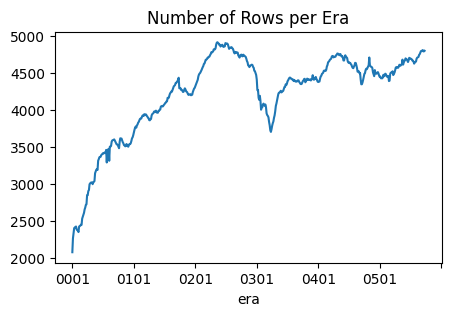

In [11]:
# Let's plot the number of rows per era
# This correspondss to the number stocks in Numerai's investable universe over time
training_data.groupby("era").size().plot(title="Number of Rows per Era", figsize=(5, 3));

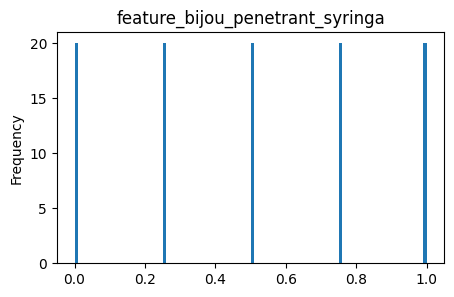

In [12]:
# Feature values are all between 0 and 1 and binned into 5 equal bins 
training_data[feature_cols[0]].plot(kind="hist", bins=100, density=True, figsize=(5, 3), title=feature_cols[0]);

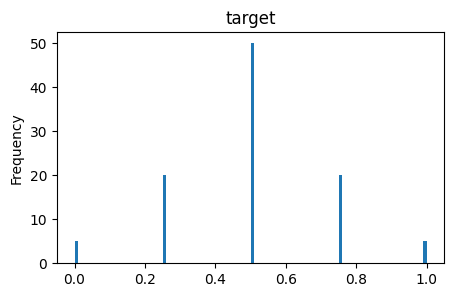

In [13]:
# The target value is also between 0 and 1 but binned into 5 unequal bins
training_data["target"].plot(kind="hist", bins=100, density=True, figsize=(5, 3), title="target");

In [14]:
###################   2) MODELLING  ############################################

In [ ]:
# Let's train a simple model using LightGBM
# This will take about 2 minutes 🍵
from lightgbm import LGBMRegressor
params = {
   "n_estimators": 2000,
   "learning_rate": 0.01,
   "max_depth": 5,
   "num_leaves": 2 ** 5,
   "colsample_bytree": 0.1
}
model = LGBMRegressor(**params)
model.fit(
   training_data[feature_cols],
   training_data["target"]
);

In [ ]:
# Let's download the validation dataset and make predictions against it to evaluate our model
# This will take about 2 minutes 🍵
napi.download_dataset("v4.1/validation.parquet")

In [ ]:
# Again we only load the "small" subset of the features to save time and memory
# This time, we will also load the "data_type" column so that we can filter against it
# In this example we will only need the rows where data_type == "validation"
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + ["target"])
validation_data = validation_data[validation_data["data_type"] == "validation"]
del validation_data["data_type"]

In [ ]:
# The structure of the validation dataset is the same as the training dataset
# Notice the eras pick up where the training dataset eras left off
validation_data

In [ ]:
# Let's make predictions against the validation dataset
# This will take about 2 minutes 🍵
predictions = model.predict(validation_data[feature_cols])
predictions

In [ ]:
# How well did our model do? 
# Let's compute the per-era correlation between our predictions and the target
# Correlation to the target or CORR is the primary metric used to evaluate Numerai models
# As you can see our model has positive correlation with the target on some eras but negative correlation on others
validation_data["prediction"] = predictions

In [ ]:
validation_data["prediction"]

In [ ]:
validation_data["prediction"] = neutralize(validation_data, "prediction", feature_cols)

In [ ]:
validation_data["prediction"] = minmax_norm(validation_data["prediction"])

In [ ]:
validation_data["prediction"]

In [ ]:
validation_data.groupby("era").apply(lambda x: x["prediction"].corr(x["target"])).plot(title="Validation Correlation", figsize=(5, 3));

In [ ]:
validation_data["prediction"].to_csv(f"validation_predictions.csv")

In [ ]:
!cp validation_predictions.csv "drive/My Drive/Cynegetic Investment Management/"

In [ ]:
#------------------------------------------------------------------------------------------------------------------#

In [ ]:
all_feature_corrs = training_data.groupby(ERA_COL).apply(lambda d: d[feature_cols].corrwith(d[TARGET_COL]))

In [ ]:
riskiest_features = get_biggest_change_features(all_feature_corrs, 350)

In [ ]:
validation_data["prediction"] = neutralize(df=validation_data,
                                              columns=["preds_4"],
                                              neutralizers=riskiest_features,
                                              proportion=1,
                                              normalize=True,
                                              era_col=ERA_COL)

In [ ]:
validation_data["prediction"] = minmax_norm(validation_data["prediction"])

In [ ]:
#-----------------------------------------------------------------------------------------------------------------#

In [ ]:
validation_data["prediction"].to_csv(f"validation_predictions.csv")

In [ ]:
!cp validation_predictions.csv "drive/My Drive/Cynegetic Investment Management/"

In [ ]:
# What is the average correlation across all eras?
# Predicting the stock is HARD, an average correlation of just 0.03 is considered a very good model
# Our model performance here is not great but it's good enough to get started
validation_data.groupby("era").apply(lambda x: x["prediction"].corr(x["target"])).mean()

0.02127943929438052

In [ ]:
#############   3) SUBMISSIONS   ###############################################

In [ ]:
# Download latest live features
napi.download_dataset("v4.1/live.parquet")
# Load live features
live_features = pd.read_parquet("v4.1/live.parquet", columns=feature_cols)
# Generate live predictions
live_predictions = model.predict(live_features[feature_cols])
# Format submission
submission = pd.Series(live_predictions, index=live_features.index).to_frame("prediction")
live_features["prediction"] = submission.values

In [ ]:
%%time
live_features["prediction"] = neutralize(live_features, "prediction", feature_cols)

In [ ]:
live_features["prediction"] 

In [ ]:
live_features["prediction"]  = minmax_norm(live_features["prediction"] )

In [ ]:
live_features["prediction"]

In [ ]:
live_features["prediction"].to_csv(f"tournament_predictions.csv")

In [ ]:
!cp tournament_predictions.csv "drive/My Drive/Cynegetic Investment Management/"

In [ ]:
#############   4) SOME IDEAS   ################################################

In [ ]:
import gc

In [ ]:
napi = NumerAPI()

current_round = napi.get_current_round()

In [ ]:
print('Downloading dataset files...')

Path("./v4").mkdir(parents=False, exist_ok=True)
napi.download_dataset("v4/train.parquet")
napi.download_dataset("v4/validation.parquet")
napi.download_dataset("v4/live.parquet", f"v4/live_{current_round}.parquet")
napi.download_dataset("v4/validation_example_preds.parquet")
napi.download_dataset("v4/features.json")

print('Reading minimal training data')
# read the feature metadata and get a feature set (or all the features)
with open("v4/features.json", "r") as f:
    feature_metadata = json.load(f)
# features = list(feature_metadata["feature_stats"].keys()) # get all the features
# features = feature_metadata["feature_sets"]["small"] # get the small feature set
features = feature_metadata["feature_sets"]["medium"] # get the medium feature set
# read in just those features along with era and target columns
read_columns = features + [ERA_COL, DATA_TYPE_COL, TARGET_COL]

v4/train.parquet: 1.15GB [01:08, 16.8MB/s]                            
v4/validation.parquet: 1.17GB [01:10, 16.7MB/s]                            
v4/live_459.parquet: 3.49MB [00:01, 2.96MB/s]                            
v4/validation_example_preds.parquet: 58.2MB [00:04, 12.0MB/s]                            
v4/features.json: 562kB [00:00, 831kB/s]                           


Reading minimal training data


In [ ]:
training_data = pd.read_parquet('v4/train.parquet', columns=read_columns)
validation_data = pd.read_parquet('v4/validation.parquet', columns=read_columns)
live_data = pd.read_parquet(f'v4/live_{current_round}.parquet', columns=read_columns)

In [ ]:
# getting the per era correlation of each feature vs the target
all_feature_corrs = training_data.groupby(ERA_COL).apply(lambda era: era[features].corrwith(era[TARGET_COL]))
# find the riskiest features by comparing their correlation vs
# the target in each half of training data; we'll use these later
riskiest_features = get_biggest_change_features(all_feature_corrs, 350)
# "garbage collection" (gc) gets rid of unused data and frees up memory
gc.collect()

21

In [ ]:
%%time
model_name = f"model_target"
print(f"Checking for existing model '{model_name}'")
model = load_model(model_name)
if not model:
    print(f"model not found, creating new one")
    params = {"n_estimators": 2000,
              "learning_rate": 0.01,
              "max_depth": 5,
              "num_leaves": 2 ** 5,
              "colsample_bytree": 0.1}

    model = LGBMRegressor(**params)

    # train on all of train and save the model so we don't have to train next time
    model.fit(training_data.filter(like='feature_', axis='columns'), training_data[TARGET_COL]) 
    print(f"saving new model: {model_name}")
    save_model(model, model_name)

gc.collect()

Checking for existing model 'model_target'
CPU times: user 271 ms, sys: 3.33 ms, total: 274 ms
Wall time: 115 ms


0

In [ ]:
nans_per_col = live_data[live_data["data_type"] == "live"][features].isna().sum()

In [ ]:
# check for nans and fill nans
if nans_per_col.any():
    total_rows = len(live_data[live_data["data_type"] == "live"])
    print(f"Number of nans per column this week: {nans_per_col[nans_per_col > 0]}")
    print(f"out of {total_rows} total rows")
    print(f"filling nans with 0.5")
    live_data.loc[:, features] = live_data.loc[:, features].fillna(0.5)

else:
    print("No nans in the features this week!")

No nans in the features this week!


In [ ]:
%%time
# double check the feature that the model expects vs what is available to prevent our
# pipeline from failing if Numerai adds more data and we don't have time to retrain!
model_expected_features = model.booster_.feature_name()

if set(model_expected_features) != set(features):
    print(f"New features are available! Might want to retrain model {model_name}.")

validation_data.loc[:, f"preds_{model_name}"] = model.predict(validation_data.loc[:, model_expected_features])

live_data.loc[:, f"preds_{model_name}"] = model.predict(live_data.loc[:, model_expected_features])

gc.collect()

CPU times: user 11min 38s, sys: 2.43 s, total: 11min 40s
Wall time: 1min 6s


23

In [ ]:
%%time
# neutralize our predictions to the riskiest features
validation_data[f"preds_{model_name}_neutral_riskiest_50"] = neutralize(
    df=validation_data,
    columns=[f"preds_{model_name}"],
    neutralizers=riskiest_features,
    proportion=1.0,
    normalize=True,
    era_col=ERA_COL
)

live_data[f"preds_{model_name}_neutral_riskiest_50"] = neutralize(
    df=live_data,
    columns=[f"preds_{model_name}"],
    neutralizers=riskiest_features,
    proportion=1.0,
    normalize=True,
    era_col=ERA_COL
)

model_to_submit = f"preds_{model_name}_neutral_riskiest_50"

CPU times: user 8min 24s, sys: 15min 12s, total: 23min 37s
Wall time: 2min 50s


In [ ]:
# rename best model to "prediction" and rank from 0 to 1 to meet upload requirements
validation_data["prediction"] = validation_data[model_to_submit].rank(pct=True)
live_data["prediction"] = live_data[model_to_submit].rank(pct=True)
validation_data["prediction"].to_csv(f"validation_predictions_{current_round}.csv")
live_data["prediction"].to_csv(f"live_predictions_{current_round}.csv")

validation_preds = pd.read_parquet('v4/validation_example_preds.parquet')
validation_data[EXAMPLE_PREDS_COL] = validation_preds["prediction"]

In [ ]:
f"live_predictions_{current_round}.csv"

'live_predictions_459.csv'

In [ ]:
!cp live_predictions_459.csv "drive/My Drive/Cynegetic Investment Management/"

In [ ]:
f"validation_predictions_{current_round}.csv"

'validation_predictions_459.csv'

In [ ]:
!cp validation_predictions_459.csv "drive/My Drive/Cynegetic Investment Management/"

In [ ]:
%%time
# get some stats about each of our models to compare...
# fast_mode=True so that we skip some of the stats that are slower to calculate
validation_stats = validation_metrics(validation_data, [model_to_submit, f"preds_{model_name}"], example_col=EXAMPLE_PREDS_COL, fast_mode=True, target_col=TARGET_COL)
print(validation_stats[["mean", "sharpe"]].to_markdown())

|                                        |      mean |   sharpe |
|:---------------------------------------|----------:|---------:|
| preds_model_target_neutral_riskiest_50 | 0.0223568 | 1.08269  |
| preds_model_target                     | 0.0268463 | 0.858707 |
CPU times: user 5min 30s, sys: 54.3 s, total: 6min 24s
Wall time: 5min 30s


In [ ]:
print(f'''
Done! Next steps:
    1. Go to numer.ai/tournament (make sure you have an account)
    2. Submit validation_predictions_{current_round}.csv to the diagnostics tool
    3. Submit tournament_predictions_{current_round}.csv to the "Upload Predictions" button
''')


Done! Next steps:
    1. Go to numer.ai/tournament (make sure you have an account)
    2. Submit validation_predictions_459.csv to the diagnostics tool
    3. Submit tournament_predictions_459.csv to the "Upload Predictions" button



In [ ]:
################################################################################
##################   FINAL EMERGENCI SUBMISSION   ##############################
################################################################################

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
class PandasDriver:
    def __init__(self, pq_path: str, splits=4):
        self.pq_path = pq_path
        self.splits = splits
        
        self.df = pd.read_parquet(pq_path)
        self.df['era'] = self.df['era'].astype('int')
    
    def get_by_group(self, group_id: int, cols=None):
        if group_id == self.splits:
            group_id = 0
        return self.df[self.df['era'] % self.splits == group_id]


import duckdb

class DuckDBDriver:
    def __init__(self, pq_path: str, splits=4):
        self.pq_path = pq_path
        self.splits = splits
        self.conn = duckdb.connect(":memory:")
        
    def _gen_select_statement(self) -> str:
        return f"SELECT * FROM parquet_scan('{self.pq_path}') "
    
    def _query(self, expression: str):
        return self. conn.execute(expression)
    
    def _fetch(self, ret_query, fetch_type, cols):
        if fetch_type == "pandas":
            return ret_query.fetchdf()
        elif fetch_type == "numpy":
            return ret_query.fetchdf()[cols].values
        
    def get_by_era(self, era: str, cols=None, fetch_type="pandas"):
        expression = self._gen_select_statement()
        expression += f"WHERE era = '{era}'"
        ret_query = self._query(expression)
        return self._fetch(ret_query, fetch_type, cols)
    
    def get_by_group(self, group_id: int, cols=None, fetch_type="pandas"):
        if group_id == self.splits:
            group_id = 0
        expression = self._gen_select_statement()
        expression += f"WHERE CAST(era AS INT) % {self.splits} = {group_id}"
        ret_query = self._query(expression)
        return self._fetch(ret_query, fetch_type, cols)

In [ ]:
example_public_id = "somepublicid"
example_secret_key = "somesecretkey"
napi = numerapi.NumerAPI(example_public_id, example_secret_key)

In [ ]:
model_id = napi.get_models()['your_model_name']
napi.upload_predictions("tournament_predictions.csv", model_id=model_id, version=2) # version=2 for the ~1K features